# Case 21.6 Segmenting Consumers of Bath Soap

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import matplotlib.pylab as plt

import dmba
from dmba import classificationSummary, gainsChart

from IPython.display import display_html

%matplotlib inline

no display found. Using non-interactive Agg backend


## Load the data

In [2]:
bathSoap_df = dmba.load_data('BathSoapHousehold.csv')
print(bathSoap_df.shape)
bathSoap_df.head()

(600, 46)


Member id  SEC  FEH  MT  SEX  AGE  EDU  HS  CHILD  CS  ...  PropCat 6  \
0    1010010    4    3  10    1    4    4   2      4   1  ...   0.000000   
1    1010020    3    2  10    2    2    4   4      2   1  ...   0.347048   
2    1014020    2    3  10    2    4    5   6      4   1  ...   0.121212   
3    1014030    4    0   0    0    4    0   0      5   0  ...   0.000000   
4    1014190    4    1  10    2    3    4   4      3   1  ...   0.000000   

   PropCat 7  PropCat 8  PropCat 9  PropCat 10  PropCat 11  PropCat 12  \
0   0.000000   0.000000   0.000000         0.0    0.000000    0.028037   
1   0.026834   0.016100   0.014311         0.0    0.059034    0.000000   
2   0.033550   0.010823   0.008658         0.0    0.000000    0.016234   
3   0.000000   0.000000   0.000000         0.0    0.000000    0.000000   
4   0.000000   0.048193   0.000000         0.0    0.000000    0.000000   

   PropCat 13  PropCat 14  PropCat 15  
0         0.0    0.130841    0.339564  
1         0.0    0.080501    0.000000  
2         0.0    0.561688    0.003247  
3         0.0    0.600000    0.000000  
4         0.0    0.144578    0.000000  

[5 rows x 46 columns]

# Step 1:
Use $k$-means clustering to identify clusters of households based on:

1. The variables that describe purchase behavior (including brand loyalty)
2. The variables that describe the basis for purchase
3. The variables that describe both purchase behavior and basis of purchase

Note 1: How should $k$ be chosen?  Think about how the clusters would be used.  It is likely that the marketing efforts would support two to five different promotional approaches.

Note 2: How should the percentages of total purchases comprised by various brands be treated?  Isn't a customer
who buys all brand A just as loyal as a customer who buys all brand B?  What will be the effect on any distance measure of using the brand share variables as is?  Consider using a single derived variable.

We look first at clusters based on purchase behavior, then clusters based on the basis for purchase, then clusters based on both. The complexity of marketing to 5 segments would probably not be supported by clustering just based on purchase behavior, or clustering just based on basis for purchase, so we will look at 2-3 clusters for those variables, and more when we cluster using both sets of variables.

In choosing  𝑘 , we would seek a  𝑘  that produces clusters that are distinct and separate from one another, in ways (variables) that are translatable into marketing actions. The variables we have been asked to consider are those that relate to purchase behavior (volume and frequency of purchase, brand loyalty), and a separate set that relate to the basis for purchase (response to promotions, pricing, and selling proposition).

In [3]:
# Group columns into sets for further analysis
demographicIndicators = bathSoap_df.columns[1:11]
purchaseIndicator = bathSoap_df.columns[11:19]
withinPromotionIndicator = bathSoap_df.columns[19:22]
brandIndicator = bathSoap_df.columns[22:30]
otherBrandIndicator = bathSoap_df.columns[30:31]
priceCategoryIndicator = bathSoap_df.columns[31:35]
sellingPropertyIndicator = bathSoap_df.columns[35:46]

print('Demographic', demographicIndicators)
print('Purchase', purchaseIndicator)
print('Promotion', withinPromotionIndicator)
print('Brand', brandIndicator)
print('Other brand', otherBrandIndicator)
print('Price category', priceCategoryIndicator)
print('Selling property', sellingPropertyIndicator)

Demographic Index(['SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD', 'CS',
       'Affluence Index'],
      dtype='object')
Purchase Index(['No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value',
       'Trans / Brand Runs', 'Vol/Tran', 'Avg. Price '],
      dtype='object')
Promotion Index(['Pur Vol No Promo - %', 'Pur Vol Promo 6 %', 'Pur Vol Other Promo %'], dtype='object')
Brand Index(['Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286',
       'Br. Cd. 24', 'Br. Cd. 481', 'Br. Cd. 352', 'Br. Cd. 5'],
      dtype='object')
Other brand Index(['Others 999'], dtype='object')
Price category Index(['Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4'], dtype='object')
Selling property Index(['PropCat 5', 'PropCat 6', 'PropCat 7', 'PropCat 8', 'PropCat 9',
       'PropCat 10', 'PropCat 11', 'PropCat 12', 'PropCat 13', 'PropCat 14',
       'PropCat 15'],
      dtype='object')


## Clusters based on "purchase behavior"
Note: Some thought is needed about brand loyalty. For brand loyalty indicators, we have data on 
    
1. percent of purchases devoted to major brands (i.e. is a customer a total devotee of brand A?), `brandIndicator` 
2. a catch-all variable for percent of purchases devoted to other smaller brands (to reduce complexity of analysis), and `otherBrandIndicator`
3. a derived variable that indicates the maximum share devoted to any one brand. 
    
Since CRISA is compiling this data for general marketing use, and not on behalf of one particular brand, we can
say a customer who is fully devoted to brand A is similar to a customer fully devoted to brand B - both
are fully loyal customers in their behavior. But if we include all the brand shares in the clustering, the
analysis will treat those two customers as very different. 

1. Number of different brands: `No. of Brands`
2. Switching between brands: `Brand Runs`
3. Proportion of purchases that go to different brands: We use the information in the `brandIndicator` to determine the maximum proportion a customer spends on one brand (new variable `maxBrandIndicator`)

We derive the value of `maxBrandIndicator` by taking the maximum of all specific brand indicators.

In [4]:
bathSoap_df['maxBrandIndicator'] = bathSoap_df[brandIndicator].max(axis=1)

For this analysis, we use all `purchaseIndicator`, `maxBrandIndicator` and `otherBrandIndicator` as a description of the customers purchase behavior

In [5]:
behaviorIndicator = list(purchaseIndicator) + list(otherBrandIndicator) + ['maxBrandIndicator']
print(behaviorIndicator)

['No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value', 'Trans / Brand Runs', 'Vol/Tran', 'Avg. Price ', 'Others 999', 'maxBrandIndicator']


### Normalizing the data and definition of helper functions

In [6]:
# Normalize the data
bathSoap_df_norm = (bathSoap_df - bathSoap_df.mean())/bathSoap_df.std()

def clusterSizes(kmeans):
    return pd.Series(kmeans.labels_).value_counts().sort_index()


def clusterCenters(kmeans, indicator):
    return bathSoap_df_norm[indicator].groupby(kmeans.labels_).mean()

### Two clusters

In [7]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[behaviorIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, behaviorIndicator)

0    317
1    283
dtype: int64


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of Brands  Brand Runs  Total Volume  No. of  Trans     Value  \
0       0.483611    0.632865      0.158222       0.522115  0.306960   
1      -0.541712   -0.708898     -0.177232      -0.584843 -0.343838   

   Trans / Brand Runs  Vol/Tran  Avg. Price   Others 999  maxBrandIndicator  
0           -0.261283 -0.285383     0.279689    0.488928          -0.588026  
1            0.292674  0.319669    -0.313291   -0.547669           0.658673

Comment: The two clusters are well-separated on everything, except transaction volume. 
- Cluster 0 (n=317) is high activity & value, with low loyalty. 
- Cluster 1 (n=283) is the reverse. 

("Value" here is the meaning attached to the variable - total dollar value of purchases, not some broader meaning.)
Note: Due to the randomization element in the k-means process, different runs can produce different
cluster results.

In [8]:
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[behaviorIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, behaviorIndicator)

0    169
1    255
2    176
dtype: int64


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


No. of Brands  Brand Runs  Total Volume  No. of  Trans     Value  \
0       0.956671    1.089336      0.614067       1.070582  0.744401   
1      -0.301247   -0.224690     -0.531892      -0.425770 -0.453789   
2      -0.482156   -0.720465      0.180994      -0.411120 -0.057315   

   Trans / Brand Runs  Vol/Tran  Avg. Price   Others 999  maxBrandIndicator  
0           -0.255378 -0.202562     0.126356    0.253722          -0.476069  
1           -0.246577 -0.266204     0.232878    0.611302          -0.536321  
2            0.602477  0.580199    -0.458739   -1.129323           1.234190

Comment: 
- Cluster 0 (n=166) is not at all loyal, favoring many brands, and of high value.
- Cluster 1 (n=259) is also not very loyal, but may be of the least interest since its customers have the lowest value.
- Cluster 2 (n=175) is highly loyal, favoring main brands and bigger individual purchases, with middling overall value. 

## Clusters based on "basis for purchase"
The variables used are: `Pur Vol No Promo - %`, `Pur Vol Promo 6 %`, `Pur Vol Other Promo %`, all price categories, selling propositions 5 and 14 (most people seemed to be responding to one or the other of these promotions/propositions).

In [9]:
purchaseBasisIndicator = list(withinPromotionIndicator) + list(priceCategoryIndicator) 
purchaseBasisIndicator.extend(['PropCat 5', 'PropCat 14'])
print(purchaseBasisIndicator)

['Pur Vol No Promo - %', 'Pur Vol Promo 6 %', 'Pur Vol Other Promo %', 'Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4', 'PropCat 5', 'PropCat 14']


In [10]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[purchaseBasisIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, purchaseBasisIndicator)

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    523
1     77
dtype: int64


Pur Vol No Promo - %  Pur Vol Promo 6 %  Pur Vol Other Promo %  Pr Cat 1  \
0             -0.030242           0.059272              -0.026365  0.116571   
1              0.205410          -0.402586               0.179079 -0.791774   

   Pr Cat 2  Pr Cat 3  Pr Cat 4  PropCat 5  PropCat 14  
0  0.166971 -0.351498  0.049271   0.162794   -0.352144  
1 -1.134101  2.387450 -0.334659  -1.105730    2.391835

Comment: The two clusters are well-separated across most variables. 
- Cluster 0 (n=77) is notable for its responsiveness to price category 3 and selling proposition 14 coupled with aversion to price categories 1 and 2, and selling proposition 5.
- Cluster 1 (n=523) shows a less clear profile

In [11]:
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[purchaseBasisIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, purchaseBasisIndicator)

0     97
1    429
2     74
dtype: int64


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pur Vol No Promo - %  Pur Vol Promo 6 %  Pur Vol Other Promo %  Pr Cat 1  \
0             -1.742234           1.605076               0.818594  0.334189   
1              0.349656          -0.287933              -0.208460  0.062932   
2              0.256679          -0.434717               0.135482 -0.802892   

   Pr Cat 2  Pr Cat 3  Pr Cat 4  PropCat 5  PropCat 14  
0 -0.265602 -0.369225  0.458320   0.002103   -0.373063  
1  0.258829 -0.336154 -0.042901   0.195635   -0.335935  
2 -1.152356  2.432767 -0.352060  -1.136908    2.436529

Comment: 
- Cluster 0 (n=74) has the same profile as cluster 0 in the two cluster case.
- Cluster 1 (n=429) corresponds mainly to cluster 1 in the two cluster case.
- Cluster 2 (n=97) needs promostions, likes price categories 1 and 4, and is not responsive to the two selling propositions. 

## Clusters based on all of the above variables

In [12]:
combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
clusterCenters(clusters, combinedIndicator).transpose()

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    527
1     73
dtype: int64


0         1
No. of Brands          0.071443 -0.515759
Brand Runs             0.106566 -0.769322
Total Volume          -0.021206  0.153087
No. of  Trans          0.054136 -0.390817
Value                  0.068413 -0.493883
Trans / Brand Runs    -0.144100  1.040286
Vol/Tran              -0.074972  0.541233
Avg. Price             0.180076 -1.299999
Others 999             0.173881 -1.255280
maxBrandIndicator     -0.194949  1.407373
Pur Vol No Promo - %  -0.027558  0.198948
Pur Vol Promo 6 %      0.057591 -0.415757
Pur Vol Other Promo % -0.028648  0.206818
Pr Cat 1               0.110774 -0.799701
Pr Cat 2               0.161535 -1.166152
Pr Cat 3              -0.336524  2.429429
Pr Cat 4               0.045662 -0.329644
PropCat 5              0.156704 -1.131277
PropCat 14            -0.336995  2.432829

Comment: The two clusters are separated on almost all variables, Value being an important exception. 

In [13]:
def clusterDemographics(kmeans):
    return bathSoap_df[demographicIndicators].groupby(kmeans.labels_).mean()

clusterDemographics(clusters).transpose()

0         1
SEC               2.371917  3.424658
FEH               2.047438  2.054795
MT                8.246679  7.684932
SEX               1.762808  1.561644
AGE               3.244782  2.986301
EDU               4.275142  2.369863
HS                4.191651  4.191781
CHILD             3.201139  3.465753
CS                0.937381  0.890411
Affluence Index  18.168880  8.726027

Cluster 1 (n=72) is the more loyal, with lower socioeconomic status, educational level, and affluence.

In [14]:
def display_side_by_side(*args):
    html_str = ''.join(df.to_html() for df in args)
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=3, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
display_side_by_side(clusterCenters(clusters, combinedIndicator).transpose(),
                     clusterDemographics(clusters).transpose())

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0     70
1    252
2    278
dtype: int64


0 
 1 
 2 
 
 
 
 
 No. of Brands 
 -0.583893 
 0.177248 
 -0.013647 
 
 
 Brand Runs 
 -0.800569 
 0.416647 
 -0.176098 
 
 
 Total Volume 
 0.083386 
 -0.307694 
 0.257921 
 
 
 No. of Trans 
 -0.433421 
 0.230518 
 -0.099824 
 
 
 Value 
 -0.555616 
 -0.002653 
 0.142308 
 
 
 Trans / Brand Runs 
 1.037226 
 -0.251914 
 -0.032818 
 
 
 Vol/Tran 
 0.513840 
 -0.496185 
 0.320395 
 
 
 Avg. Price 
 -1.318253 
 0.712855 
 -0.314251 
 
 
 Others 999 
 -1.264136 
 0.507151 
 -0.141412 
 
 
 maxBrandIndicator 
 1.421065 
 -0.537156 
 0.129097 
 
 
 Pur Vol No Promo - % 
 0.210216 
 -0.432223 
 0.338867 
 
 
 Pur Vol Promo 6 % 
 -0.436005 
 0.437706 
 -0.286984 
 
 
 Pur Vol Other Promo % 
 0.214271 
 0.152045 
 -0.191778 
 
 
 Pr Cat 1 
 -0.797226 
 0.853929 
 -0.573325 
 
 
 Pr Cat 2 
 -1.220714 
 -0.351743 
 0.626220 
 
 
 Pr Cat 3 
 2.495499 
 -0.425507 
 -0.242652 
 
 
 Pr Cat 4 
 -0.336964 
 -0.084561 
 0.161500 
 
 
 PropCat 5 
 -1.142977 
 -0.217019 
 0.484522 
 
 
 PropCat 14 
 2.498321 
 -0.425938 
 -0.242972 
 
 
 
 
 
 
 0 
 1 
 2 
 
 
 
 
 SEC 
 3.400000 
 2.047619 
 2.683453 
 
 
 FEH 
 2.042857 
 1.916667 
 2.169065 
 
 
 MT 
 7.671429 
 7.817460 
 8.633094 
 
 
 SEX 
 1.542857 
 1.722222 
 1.802158 
 
 
 AGE 
 3.014286 
 3.250000 
 3.230216 
 
 
 EDU 
 2.357143 
 4.515873 
 4.039568 
 
 
 HS 
 3.914286 
 3.746032 
 4.665468 
 
 
 CHILD 
 3.514286 
 3.313492 
 3.089928 
 
 
 CS 
 0.871429 
 0.904762 
 0.971223 
 
 
 Affluence Index 
 8.542857 
 20.599206 
 15.910072

Comment:
- Cluster 0: (n=72) Highly loyal, low value, highly responsive to price category 3 and selling proposition 14.
- Cluster 1: (n=252) Responsive to price category 2 and selling proposition 5, otherwise somewhat middling.
- Cluster 2: (n=278) Low brand loyalty, responsive to price category 1

In [15]:
combinedIndicator = behaviorIndicator + purchaseBasisIndicator 
clusters = KMeans(n_clusters=4, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))
display_side_by_side(clusterCenters(clusters, combinedIndicator).transpose(),
                     clusterDemographics(clusters).transpose())

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    108
1     70
2    202
3    220
dtype: int64


0 
 1 
 2 
 3 
 
 
 
 
 No. of Brands 
 -0.414750 
 -0.583893 
 0.831690 
 -0.374254 
 
 
 Brand Runs 
 -0.323453 
 -0.800569 
 0.968608 
 -0.475846 
 
 
 Total Volume 
 -0.652097 
 0.083386 
 0.296096 
 0.021719 
 
 
 No. of Trans 
 -0.428001 
 -0.433421 
 0.822379 
 -0.407077 
 
 
 Value 
 -0.217635 
 -0.555616 
 0.388601 
 -0.073181 
 
 
 Trans / Brand Runs 
 -0.137290 
 1.037226 
 -0.297963 
 0.010955 
 
 
 Vol/Tran 
 -0.457723 
 0.513840 
 -0.355763 
 0.387861 
 
 
 Avg. Price 
 1.362917 
 -1.318253 
 0.057415 
 -0.302341 
 
 
 Others 999 
 0.523047 
 -1.264136 
 0.371432 
 -0.195586 
 
 
 maxBrandIndicator 
 -0.428661 
 1.421065 
 -0.554702 
 0.267594 
 
 
 Pur Vol No Promo - % 
 0.193274 
 0.210216 
 -0.477723 
 0.276870 
 
 
 Pur Vol Promo 6 % 
 -0.186015 
 -0.436005 
 0.585153 
 -0.307232 
 
 
 Pur Vol Other Promo % 
 -0.080532 
 0.214271 
 0.037105 
 -0.062712 
 
 
 Pr Cat 1 
 1.650767 
 -0.797226 
 0.042110 
 -0.595378 
 
 
 Pr Cat 2 
 -0.826802 
 -1.220714 
 0.133018 
 0.672159 
 
 
 Pr Cat 3 
 -0.478654 
 2.495499 
 -0.267225 
 -0.313686 
 
 
 Pr Cat 4 
 -0.405680 
 -0.336964 
 0.095734 
 0.218467 
 
 
 PropCat 5 
 -0.372115 
 -1.142977 
 -0.071708 
 0.612190 
 
 
 PropCat 14 
 -0.472132 
 2.498321 
 -0.270314 
 -0.314949 
 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 SEC 
 1.787037 
 3.400000 
 2.376238 
 2.677273 
 
 
 FEH 
 1.657407 
 2.042857 
 2.237624 
 2.068182 
 
 
 MT 
 6.703704 
 7.671429 
 9.029703 
 8.281818 
 
 
 SEX 
 1.472222 
 1.542857 
 1.920792 
 1.763636 
 
 
 AGE 
 3.157407 
 3.014286 
 3.326733 
 3.200000 
 
 
 EDU 
 4.157407 
 2.357143 
 4.623762 
 3.990909 
 
 
 HS 
 3.037037 
 3.914286 
 4.702970 
 4.377273 
 
 
 CHILD 
 3.546296 
 3.514286 
 3.039604 
 3.168182 
 
 
 CS 
 0.740741 
 0.871429 
 1.044554 
 0.940909 
 
 
 Affluence Index 
 17.944444 
 8.542857 
 20.871287 
 15.727273

Comment:
- Cluster 0 (n=109) is characterized by low volume, low loyalty, and sensitivity to promotions and price (responsive to cat. 1, unresponsive to 2 and 3), and unmoved by selling proposition. Demographically, it is affluent, of high socio-economic status, and has relatively small family size.
- Cluster 1 (n=201) is distinguished mostly by the purchase behavior variables - it has low brand loyalty together with high value, volume and frequency. The brand switching seems to be intrinsic - this group is not particularly responsive to promotions, pricing or selling propositions. Demographically it is relatively affluent and educated.
- Cluster 2 (n=70) stands out in both groups of variables - it has high loyalty, low value and price per purchase, and very differential response to price (unresponsive to categories 1, 2 and 4, highly responsive to category 3), and selling proposition (unresponsive to #5, highly responsive to #14). Demographically it has low affluence and education.
- Cluster 3 (n=220) is a "gray" cluster, it is not characterized by very extreme/distinctive values across all variables, but is responsive to price category 2 and selling proposition 5 (similar to cluster 1 in the 3-cluster analysis). Demographically it is relatively affluent and educated. 

# Step 2:
Select what you think is the best segmentation and comment on the characteristics (demographic, brand loyalty, and basis for purchase) of these clusters.  (This information would be used to guide the development of advertising and promotional campaigns.)

There is no single "right" approach to clustering; different approaches are feasible depending on
different marketing purposes. CRISA is a marketing agency and owns the data, which it collected at
considerable expense, so it will want to be able to use both the data and the segmentation analysis in
different ways for different clients. Here are just a few possible marketing approaches:

1. Establishing named customer "personas," corresponding to the cluster segments, for use by a client's sales and marketing teams.
2. Establishing named customer "personas," corresponding to the cluster segments, for use by CRISA in providing marketing services to clients.
3. "Capture affluent market share" campaign for a client who wants to target more affluent consumers who are not wedded to their current brand, and secure more brand share. 
4. "Down market" campaign for a data-poor client to build a "value" brand for less affluent consumers, much as Dollar General has done in the U.S. 

note: The difference between #1 and #2 is that #1, being confined to a single client, can use that client's
customer data to refine and do more analysis. #2 would have to rely on the data collected by CRISA.

# Step 3:
Develop a model that classifies the data into these segments. Since this information would most likely be used in targeting direct-mail promotions, it would be useful to select a market segment that would be defined as a _success_ in the classification model.

This "down market" scenario is the one we will explore further to develop a predictive model, and classify people into either "value conscious" or not. "Data poor" means that the client has, or can get, demographic data on their customers, but not detailed purchase data (particularly involving other brands). So a predictive model is to be built using just demographic data. We will look at the results of clustering into two segments based on CRISA's own detailed purchase data, then classify people into those two segments.

Recall our characterization of the two segments:

Comment: The two clusters are separated on almost all variables, Value being an important exception. Cluster 1 (n=72) is the more loyal, with lower socioeconomic status and affluence.

So our "success" category is cluster 1, the less affluent group, lower socioeconomic group, which also turns out to be highly loyal and, as it happens, spends roughly as much as the more affluent group. This is a promising group around which to build a down-market brand strategy.

To build the model, we will be able to only use demographic information. CRISA will not have the detailed purchase information for its client's customers.

In [16]:
clusters = KMeans(n_clusters=2, random_state=1).fit(bathSoap_df_norm[combinedIndicator])
print(clusterSizes(clusters))

modelData_df = bathSoap_df[demographicIndicators].copy()
modelData_df = pd.get_dummies(modelData_df, columns=['MT', 'FEH'])
modelData_df['y'] = [1 if label == 1 else 0 for label in clusters.labels_]

train_df, valid_df = train_test_split(modelData_df, test_size=0.4, random_state=1)

train_X, train_y = train_df.drop(columns=['y']), train_df['y']
valid_X, valid_y = valid_df.drop(columns=['y']), valid_df['y']

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    527
1     73
dtype: int64


### Logistic regression

Confusion Matrix (Accuracy 0.8792)

       Prediction
Actual   0   1
     0 206   2
     1  27   5
Number of customers of interest in validaton set 32
Number of customers of interest in 20% top-ranked 19
Ratio 0.59


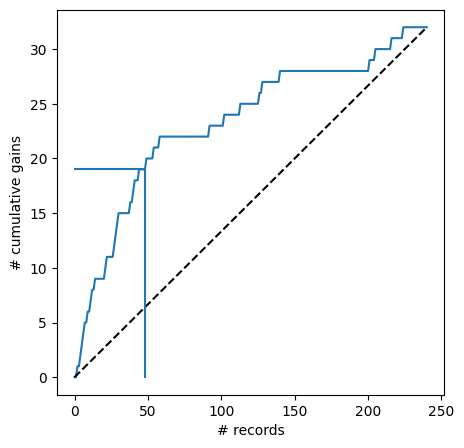

In [17]:
model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Decision tree

Confusion Matrix (Accuracy 0.8792)

       Prediction
Actual   0   1
     0 201   7
     1  22  10
Number of customers of interest in validaton set 32
Number of customers of interest in 20% top-ranked 18
Ratio 0.56


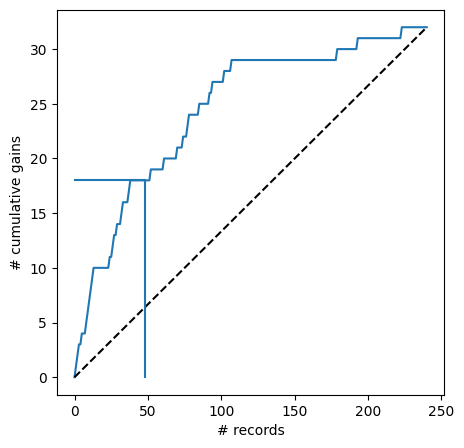

In [18]:
model = DecisionTreeClassifier(max_depth=3, random_state=1)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Random forest classifier

Confusion Matrix (Accuracy 0.8542)

       Prediction
Actual   0   1
     0 200   8
     1  27   5
Number of customers of interest in validaton set 32
Number of customers of interest in 20% top-ranked 19
Ratio 0.59


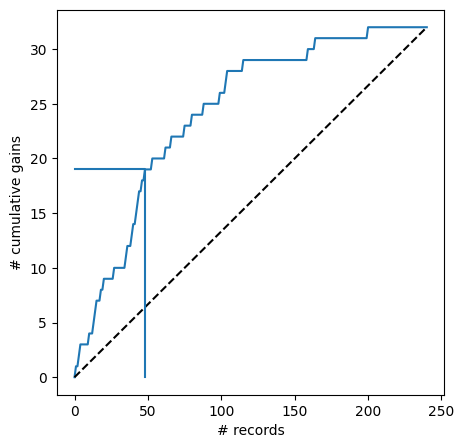

In [19]:
model = RandomForestClassifier(random_state=1, n_estimators=100)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

###  Bagging classifier

Confusion Matrix (Accuracy 0.8542)

       Prediction
Actual   0   1
     0 197  11
     1  24   8
Number of customers of interest in validaton set 32
Number of customers of interest in 20% top-ranked 20
Ratio 0.62


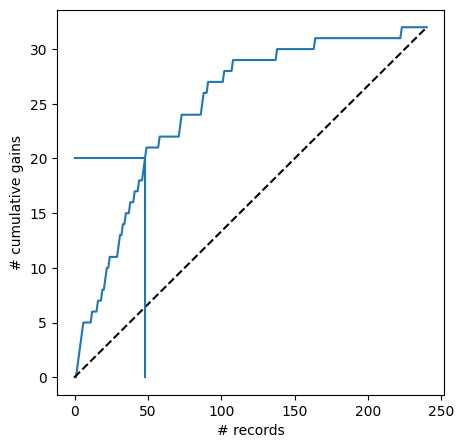

In [20]:
model = BaggingClassifier(random_state=1, n_estimators=100)
model.fit(train_X, train_y)

model_pred = model.predict_proba(valid_X)
result = pd.DataFrame({
    'actual': valid_y,
    'p(0)': [p[0] for p in model_pred],
    'p(1)': [p[1] for p in model_pred],
    'predicted': model.predict(valid_X),
})
result = result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(result.actual, result.predicted)

ax = gainsChart(result.actual, figsize=[5, 5])
nx = round(valid_df.shape[0] * 0.2)
ny = sum(result.actual[0:nx])
ax.plot([nx, nx,0], [0, ny, ny])

print('Number of customers of interest in validaton set', valid_y.sum())
print('Number of customers of interest in 20% top-ranked', ny)
print(f'Ratio {ny / valid_y.sum():.2f}')

### Summary
The analysis of the varies models favors the boosting model. It has both the highest accuracy and the gains chart shows that more records are correctly assigned for 20% of the ranked validation set.

## What's next?
Many data mining algorithms are iterative in an mathematical sense - iteration is used to find a good, if
not best, solution. The modeling process itself is also iterative. In initial exploration, we do not seek the
perfect model, merely something to get started. Results are assessed, and we typically continue with a
modified approach.

Several steps can be explored next to improve predictive performance:

1. Some of the demographic categorical variables may not have much value being treated as is, as ordered categorical variables. They could be reviewed and turned into binary dummies.
2. Instead of using a two-cluster model, a multi-cluster model could be used in hopes of deriving more distinguishable clusters. The non-success clusters could then be consolidated. For example, cluster #2 in the 4-cluster model is similar to our cluster 1 ("success") in the 2-cluster model, only more sharply defined.
3. Demographic predictors could be added to the original clustering process.
4. The clustering process, which includes a randomization component that yields variability in resulting clusters, can be repeated, to ensure that the cluster labels reflect some degree of stability. Repetition should show some clustering results that are consistent across various runs. Choosing for your labels a clustering result that is very inconsistent with the others could mean that you are labeling your market segments according to a chance fluke.
5. In the real world, going beyond the parameters of this case study, CRISA would probably work with the client to add the client's own purchase data to the model to improve it over time.